## [LLM Application Intent Classification](https://langfuse.com/guides/cookbook/example_intent_classification_pipeline)

This guide demonstrates how to build an intent classification pipeline using Langfuse trace data. With both supervised and unsupervised approaches, you can automate the labeling and analysis of traces from your Langfuse projects.

Why is this useful?

* LLM applications often contain a number of mixed intents
* Breaking down evaluations by intent helps to identify which groups of traces perform badly in production
* Measuring the volume/intent is necessary to make sure that datasets used for offline/development evaluation are representative of production usage

You can approach intent classification in two ways:

**Supervised approach**: You provide a model with labeled training data, and the model will output one of the pre-defined labels when making predictions.

**Unsupervised approach**: The model attempts to find clusters within the data, which you can then label appropriately.


By the end of this notebook, you’ll have two basic pipelines that will:

1. Extract trace data from one of your Langfuse projects.
2. Train an intent classification model.
3. Predict the intent of traces using both supervised and unsupervised approaches.
4. Upload predicted intent results back to Langfuse as tags.

### Step1: Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Install Langfuse
%pip install --quiet "langfuse"
# Install dependencies for supervised intent classification
%pip install --quiet pandas scikit-learn sentence-transformers torch transformers
# Install dependencies for unsupervised intent recognition
%pip install --quiet chromadb hdbscan openai

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Configure your Langfuse project credentials (retrieve these from your Langfuse Project Settings):

In [2]:
import os
 
# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1" 
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a" 
LANGFUSE_HOST="http://localhost:3000"

# Your openai key
os.environ["OPENAI_API_KEY"] = "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"

In [3]:
from langfuse import get_client
 
langfuse = get_client()
 
# Verify connection, do not use in production as this is a synchronous call
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


Select an embedding model from the Sentence Transformers library:

In [26]:
# Select embedding model
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-mpnet-base-v2")

Overriding of current TracerProvider is not allowed


### Step2: Supervised intent classification pipeline (dummy data)

This section outlines the process of creating a supervised intent classification model with Langfuse trace data. The steps include retrieving trace data, using scikit-learn and sentence transformers to build and train the model, predicting intents, and tagging traces with labels in Langfuse. This method requires labeled data but ensures consistent predictions for predefined intents, ideal for clearly defined intent identification.

#### 1. Retrieve Langfuse traces

In [64]:
# （适用于 Langfuse 3.x）

from langfuse import get_client
client = get_client()


In [6]:
# 查看 trace 相关方法
trace_methods = [method for method in dir(client) if not method.startswith('_')]
print("Trace methods:", trace_methods)

Trace methods: ['api', 'async_api', 'auth_check', 'create_dataset', 'create_dataset_item', 'create_event', 'create_prompt', 'create_score', 'create_trace_id', 'flush', 'get_current_observation_id', 'get_current_trace_id', 'get_dataset', 'get_prompt', 'get_trace_url', 'resolve_media_references', 'score_current_span', 'score_current_trace', 'shutdown', 'start_as_current_generation', 'start_as_current_span', 'start_generation', 'start_span', 'update_current_generation', 'update_current_span', 'update_current_trace', 'update_prompt']


##### Optional: Create dummy trace data

In [168]:
sample_utterances = [
    "Hello again",
    "Can you do anything else?",
    "Could you recommend a good book?",
    "I'd like to watch a drama",
    "Please revert to the beginning"
]
 
# Create dummy traces
for utterance in sample_utterances:
    with client.start_as_current_span(
        name = "intent_classification_trace",
        input = {"message": utterance}
    ) as span:
        span.update(output={"processed": True})


Fetch data from your project

In [172]:
# 查看 trace 相关方法
trace_api_methods = [method for method in dir(client.api) if not method.startswith('_')]
print("Trace api methods:", trace_api_methods)

AttributeError: 'OpenAI' object has no attribute 'api'

In [170]:
try:
    traces = client.api.trace.list()
    print(f"Fetched {len(traces.data)} traces")
    
    if traces.data:
        print("First trace example:")
        print(traces.data[0].dict())
        
except Exception as e:
    print(f"Error fetching traces: {e}")

Error fetching traces: 'OpenAI' object has no attribute 'api'


Construct a DataFrame for analysis:

In [171]:
traces_list = [
    [trace.id, trace.input.get("message", "")]
    for trace in traces.data
    if getattr(trace, "input", None) and "message" in trace.input
]

print(f"Total valid traces: {len(traces_list)}")

for trace_id, message in traces_list:
    print(f"Trace ID: {trace_id} | Message: {message}")


import pandas as pd
traces_df = pd.DataFrame(traces_list, columns=["trace_id", "message"])
print(traces_df.head())


AttributeError: 'list' object has no attribute 'data'

#### 2. Build and train an intent classification model

Prepare a small labeled dataset:

In [171]:
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm

Split the data and define an embedding transformer:

In [172]:
# Note: This is a very small dataset.
# More data will help make the model  more accurate and avoid overfitting.
sample_data = {
    "text": [
        # Greeting utterances
        "hi",
        "hello",
        "howdy",
        "hey there",
        "greetings",
        "Nice to see you",
        "Let's start",
        "begin",
        "good morning",
        "Good afternoon",
        # Menu utterances
        "I want to talk about something else",
        "options",
        "menu, please",
        "Could we chat about another subject",
        "I want to see the menu",
        "switch topics",
        "What else can you do",
        "discuss about something else",
        "Show me the menu",
        "Can we do something else",
        # Restart utterances
        "restart",
        "I'd like to do this again",
        "let me try again",
        "one more time",
        "Can I review that?",
        "check again",
        "redo",
        "again please",
        "that was great, let's start from the beginning",
        "go back to start",
    ],
    "intent": [
        "greeting",
        "greeting",
        "greeting",
        "greeting",
        "greeting",
        "greeting",
        "greeting",
        "greeting",
        "greeting",
        "greeting",
        "menu",
        "menu",
        "menu",
        "menu",
        "menu",
        "menu",
        "menu",
        "menu",
        "menu",
        "menu",
        "restart",
        "restart",
        "restart",
        "restart",
        "restart",
        "restart",
        "restart",
        "restart",
        "restart",
        "restart",
    ]
}

In [173]:
df = pd.DataFrame(sample_data)
df.head()

,text,intent
0,hi,greeting
1,hello,greeting
2,howdy,greeting
3,hey there,greeting
4,greetings,greeting


In [174]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"],
    df["intent"],
    test_size=0.5,
    random_state=14
)

In [175]:
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.embedding_model = embedding_model
 
    def transform(self, X):
        return self.embedding_model.encode(list(X))
 
    def fit(self, X, y=None):
        return self

In [176]:
pipeline = Pipeline([
    ('encoder', Encoder()),
    ('clf', LogisticRegression()),
])

In [177]:
pipeline.fit(X_train, y_train)

,steps,"[('encoder', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None


In [178]:
y_pred = pipeline.predict(X_test)
y_pred

array(['greeting', 'menu', 'menu', 'greeting', 'restart', 'greeting',
       'restart', 'menu', 'greeting', 'greeting', 'restart', 'greeting',
       'menu', 'menu', 'menu'], dtype=object)

In [179]:
single_pred = pipeline.predict(["Please let's move on"])
single_pred

array(['menu'], dtype=object)

In [180]:
probas = pipeline.predict_proba(["Please let's move on"])
probas

array([[0.30275491, 0.39219676, 0.30504833]])

In [181]:
confidence_score = float(np.max(probas, axis=1)[0])
confidence_score

0.39219676028769684

In [182]:
print("y_test:", y_test.values)
print("y_pred:", y_pred)

y_test: ['greeting' 'menu' 'menu' 'greeting' 'restart' 'greeting' 'restart'
 'restart' 'greeting' 'greeting' 'restart' 'restart' 'menu' 'menu'
 'restart']
y_pred: ['greeting' 'menu' 'menu' 'greeting' 'restart' 'greeting' 'restart' 'menu'
 'greeting' 'greeting' 'restart' 'greeting' 'menu' 'menu' 'menu']


In [183]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

    greeting       0.83      1.00      0.91         5
        menu       0.67      1.00      0.80         4
     restart       1.00      0.50      0.67         6

    accuracy                           0.80        15
   macro avg       0.83      0.83      0.79        15
weighted avg       0.86      0.80      0.78        15



#### 3. Run predictions on traces

In [ ]:
for index, row in traces_df.iterrows():
    result = pipeline.predict([row['message']])
    probas = pipeline.predict_proba([row['message']])
    confidence_score = float(np.max(probas, axis=1)[0])

    traces_df.at[index, "label"] = "".join(result)
    traces_df.at[index, "confidence_score"] = confidence_score

traces_df
    

,trace_id,message,label,confidence_score
0,75903579ac3aed41a0833a85da86d590,Please revert to the beginning,restart,0.361759
1,991d638ff2c44f59fbc53ed2571f43d1,Could you recommend a good book?,menu,0.427938
2,2346e033f1546e3337bf6250b2237824,I'd like to watch a drama,menu,0.465051
3,1ddb29615c3d73782c824e219b7b4512,Can you do anything else?,menu,0.566038
4,ed1cec6c30d60f4a8de98e0696111324,Hello again,greeting,0.518041
5,6a068e1455fcb59c9e07c502ecdf72dc,I'd like to watch a drama,menu,0.465051
6,601e5a691dcc38623e46c879f2263289,Please revert to the beginning,restart,0.361759
7,af5ccf42a2b0cf0b461defcccbc06935,Could you recommend a good book?,menu,0.427938
8,960b449e41fc99f3b133452b91414673,Can you do anything else?,menu,0.566038
9,4492e84157a2b1855d5096e65c3347cc,Hello again,greeting,0.518041


#### 4. Tag traces with labels

In [ ]:
# Note: This will add to existing tags, not add duplicate tags.
for index, row in traces_df.iterrows():
    if row['confidence_score'] > 0.3:
        trace_id = row['trace_id']
        label = row['label']
        
        with client.start_as_current_span(
            name="add_classification_tag",
            trace_context={"trace_id": trace_id},
        ) as span:
            span.update_trace(tags=[label])
            span.update(output={"result": label, "confidence": row['confidence_score']})

[one trace url](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces?pageIndex=2&pageSize=50&peek=ed1cec6c30d60f4a8de98e0696111324&timestamp=2025-07-30T09%3A12%3A03.457Z&display=timeline)


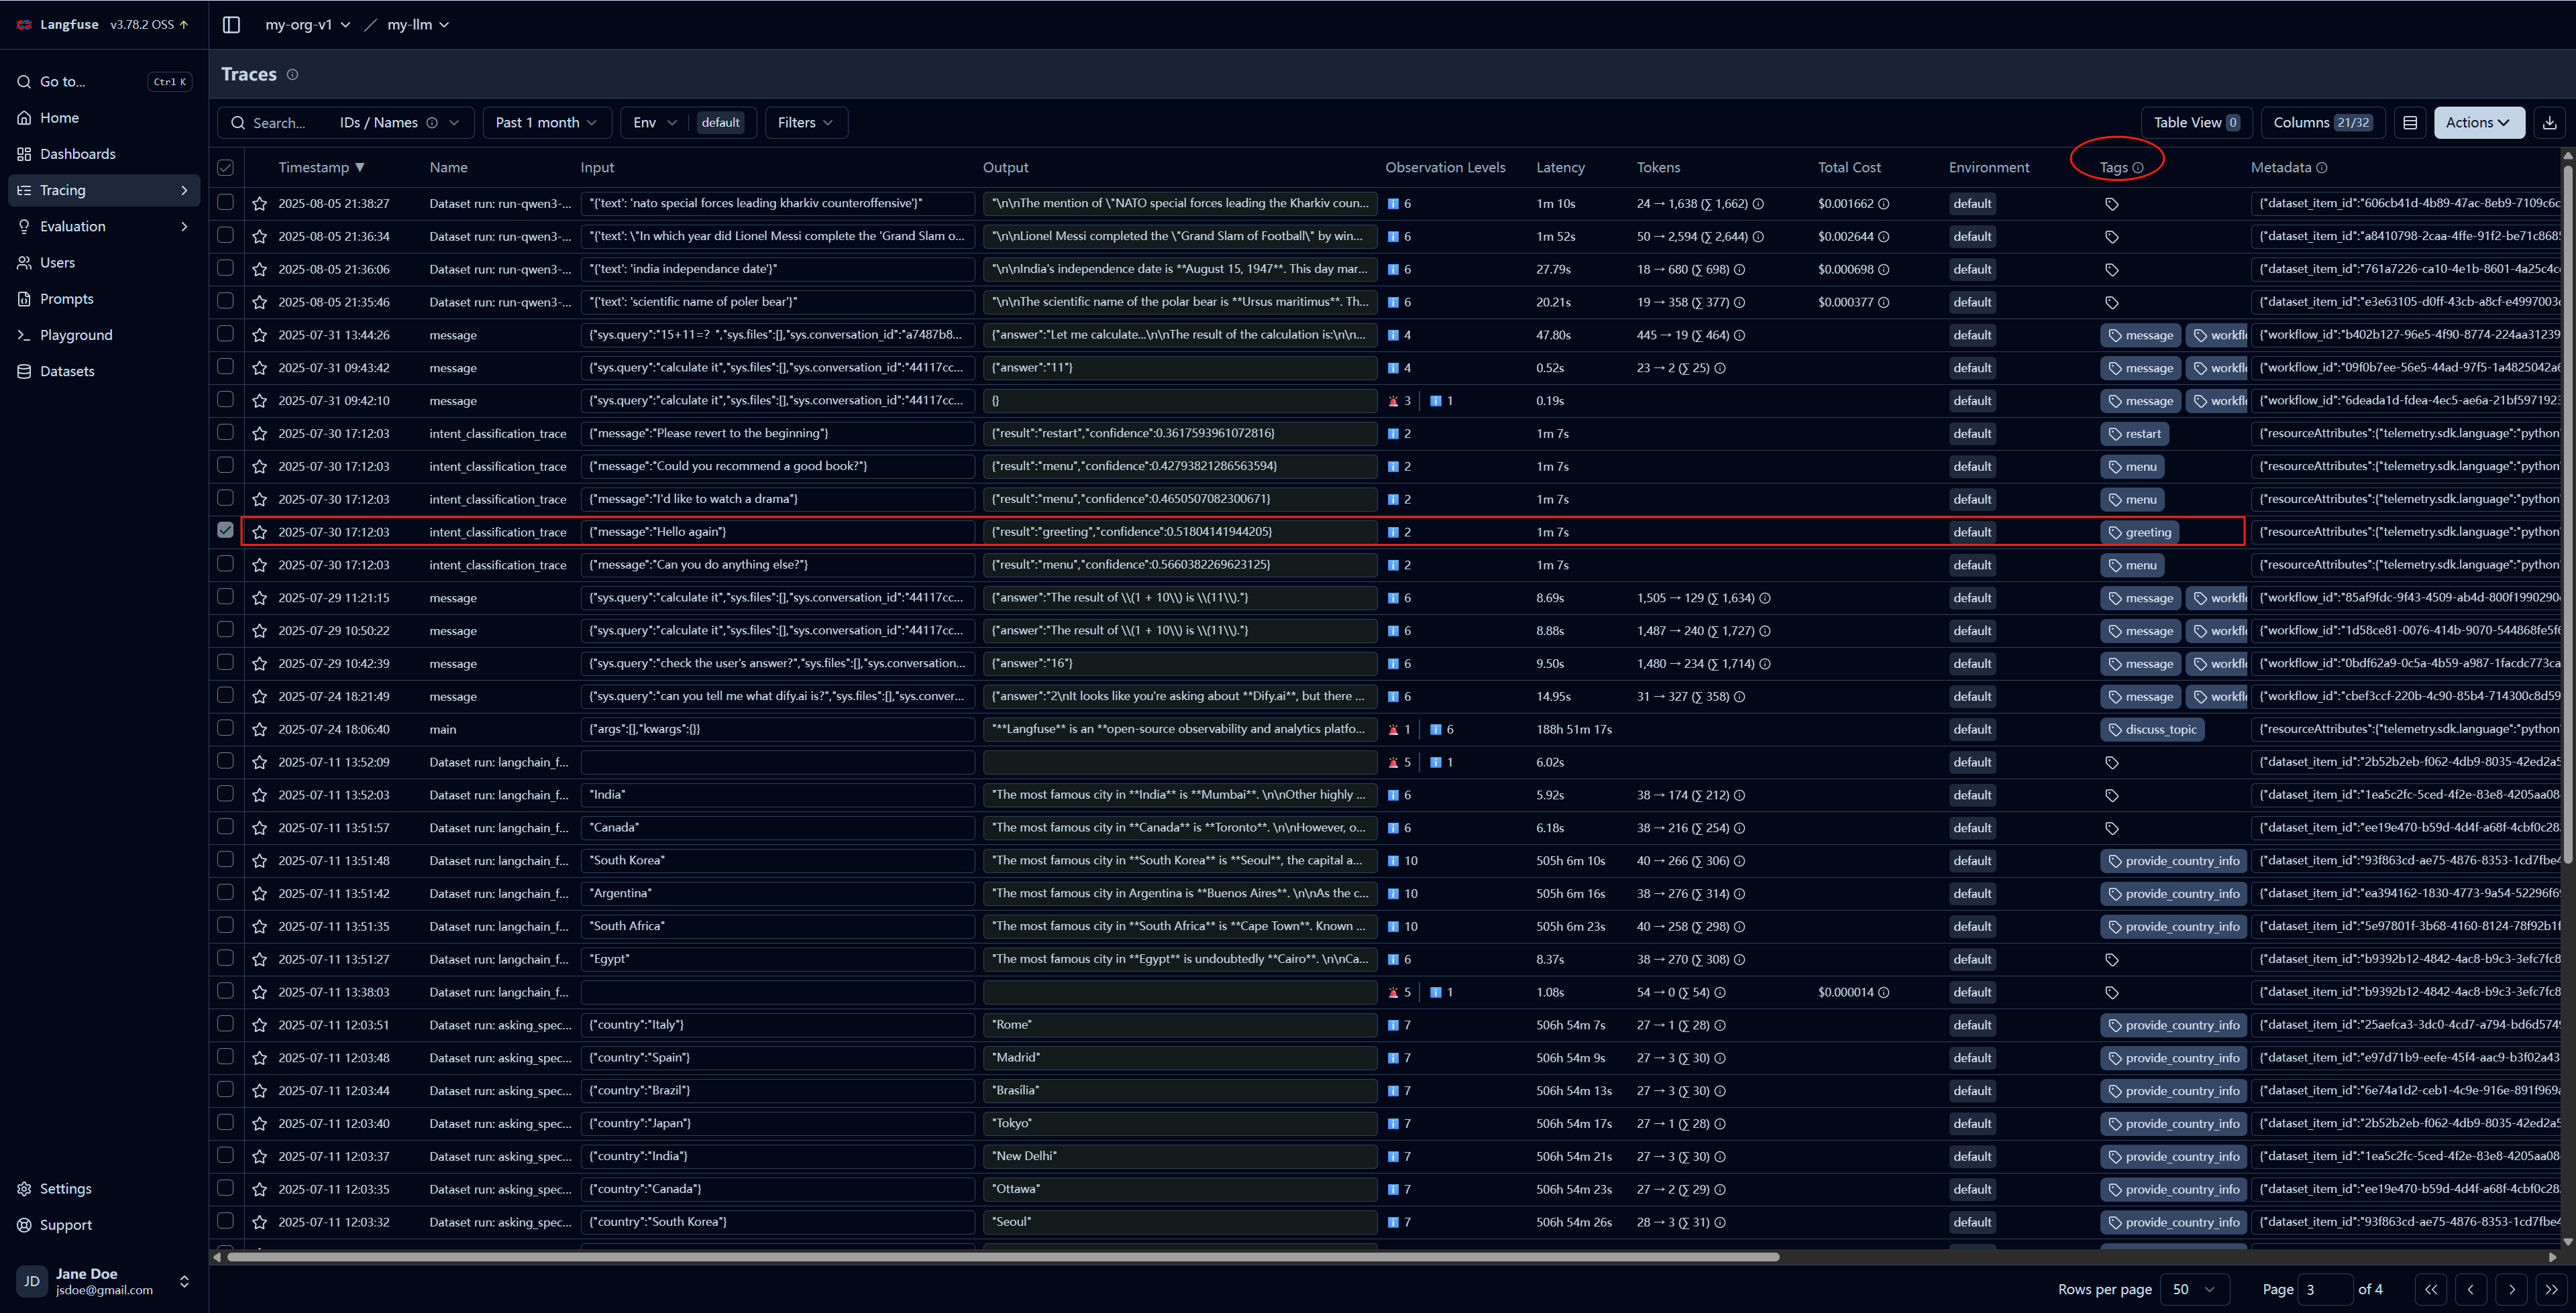




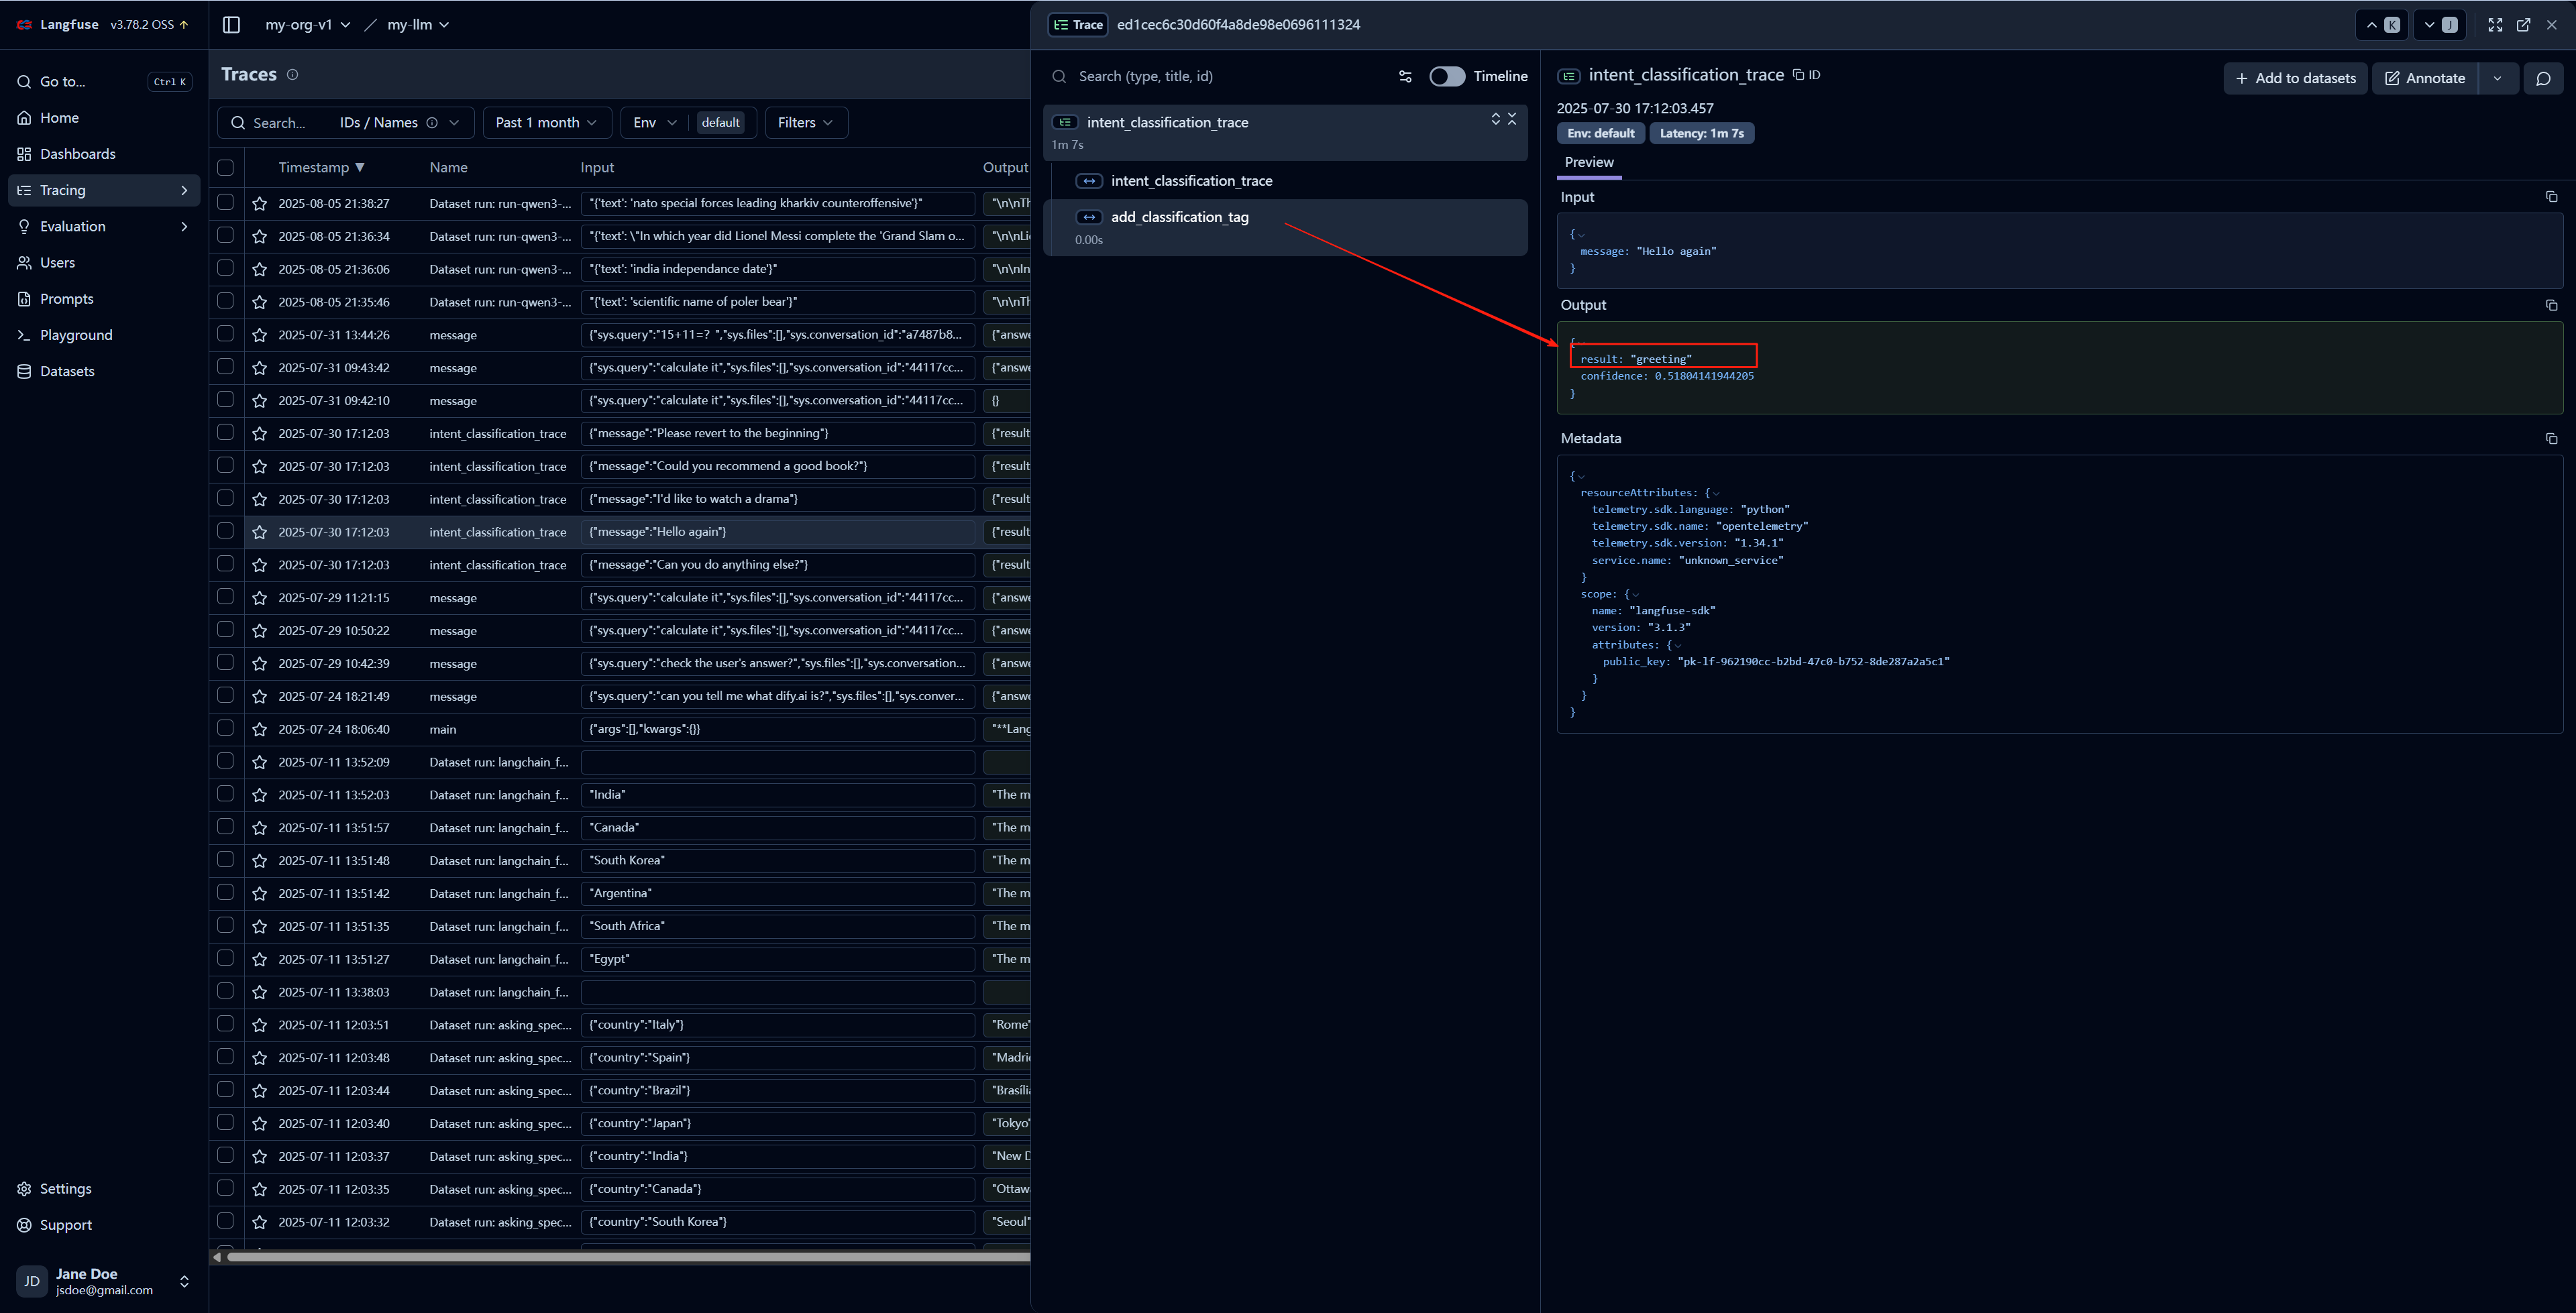

### Step3: Unsupervised intent classification pipeline (production data)

The unsupervised intent classification pipeline demonstrates how to cluster and label Langfuse trace data without predefined categories. It uses embedding techniques, clustering algorithms, and LLM-generated labels to automatically identify and tag intents, offering flexibility for unlabeled data but potentially less consistency than supervised methods.

In [2]:
import os
 
# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1" 
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a" 
LANGFUSE_HOST="http://localhost:3000"

# Your openai key
os.environ["OPENAI_API_KEY"] = "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"

In [3]:
# （适用于 Langfuse 3.x）

from langfuse import get_client
langfuse = get_client()

#### 1. Fetch traces from Langfuse

In [4]:
PAGES_TO_FETCH = 300

traces = []
for i in range(PAGES_TO_FETCH):
    traces_page = langfuse.api.trace.list(page=i+1)
    traces.extend(traces_page.data)

In [5]:
traces

[TraceWithDetails(id='9877dbe1-d15e-446e-ad46-69583c62c850', timestamp=datetime.datetime(2025, 7, 31, 5, 44, 26, 681000, tzinfo=datetime.timezone.utc), name='message', input={'sys.query': '15+11=？', 'sys.files': [], 'sys.conversation_id': 'a7487b89-9158-414c-b587-0f39fb390c6b', 'sys.user_id': 'e5209db2-217f-447a-a960-5efa30ab89f6', 'sys.dialogue_count': 13, 'sys.app_id': '730ffb0b-b7db-4610-851a-1ce409926332', 'sys.workflow_id': 'b402b127-96e5-4f90-8774-224aa3123991', 'sys.workflow_run_id': '9e21c60e-9112-4fe7-91f6-9680eefe5e8b'}, output={'answer': 'Let me calculate...\n\nThe result of the calculation is:\n\n15 + 11 = 26'}, session_id='a7487b89-9158-414c-b587-0f39fb390c6b', release=None, version='2025-07-31 05:43:15.420477', user_id='e5209db2-217f-447a-a960-5efa30ab89f6', metadata={'workflow_id': 'b402b127-96e5-4f90-8774-224aa3123991', 'conversation_id': 'a7487b89-9158-414c-b587-0f39fb390c6b', 'workflow_run_id': '9e21c60e-9112-4fe7-91f6-9680eefe5e8b', 'tenant_id': '85efb4ac-526c-427b-8

In [6]:
traces_list = []
for trace in traces:
    trace_info = [trace.id, trace.input]
    traces_list.append(trace_info)

In [7]:
traces_list

[['9877dbe1-d15e-446e-ad46-69583c62c850',
  {'sys.query': '15+11=？',
   'sys.files': [],
   'sys.conversation_id': 'a7487b89-9158-414c-b587-0f39fb390c6b',
   'sys.user_id': 'e5209db2-217f-447a-a960-5efa30ab89f6',
   'sys.dialogue_count': 13,
   'sys.app_id': '730ffb0b-b7db-4610-851a-1ce409926332',
   'sys.workflow_id': 'b402b127-96e5-4f90-8774-224aa3123991',
   'sys.workflow_run_id': '9e21c60e-9112-4fe7-91f6-9680eefe5e8b'}],
 ['4388e917-1516-4dc2-9120-9a1c91b05502',
  {'sys.query': 'calculate it',
   'sys.files': [],
   'sys.conversation_id': '44117cc2-c962-42cb-9e99-38f8255673ba',
   'sys.user_id': 'f6f5b0c6-5d3a-4232-8e22-52bb9420e4d7',
   'sys.dialogue_count': 7,
   'sys.app_id': 'a959c4f0-0057-4177-9557-c1b52d9ff84b',
   'sys.workflow_id': '09f0b7ee-56e5-44ad-97f5-1a4825042a61',
   'sys.workflow_run_id': 'bcd74346-e0d9-494b-90ed-ccfb088ec1f0'}],
 ['4b5c0796-048a-49aa-89c2-b3eb71ca9354',
  {'sys.query': 'calculate it',
   'sys.files': [],
   'sys.conversation_id': '44117cc2-c962-42c

In [9]:
import pandas as pd
cluster_traces_df = pd.DataFrame(traces_list, columns=["trace_id", "message"])
cluster_traces_df.dropna(inplace=True) # drop traces with message = None

In [10]:
cluster_traces_df

,trace_id,message
0,9877dbe1-d15e-446e-ad46-69583c62c850,"{'sys.query': '15+11=？', 'sys.files': [], 'sys..."
1,4388e917-1516-4dc2-9120-9a1c91b05502,"{'sys.query': 'calculate it', 'sys.files': [],..."
2,4b5c0796-048a-49aa-89c2-b3eb71ca9354,"{'sys.query': 'calculate it', 'sys.files': [],..."
3,75903579ac3aed41a0833a85da86d590,{'message': 'Please revert to the beginning'}
4,991d638ff2c44f59fbc53ed2571f43d1,{'message': 'Could you recommend a good book?'}
...,...,...
128,e6f972629a9c7afee84a9a08eb4e7dde,"{'args': [], 'kwargs': {}}"
129,b8bdbc2c969c1dba751d22e9772f9c25,"{'args': [], 'kwargs': {}}"
130,b2265775ecda01c60b2a8cf402a2a5e6,"{'args': [], 'kwargs': {}}"
131,b77c374d30c2621ec168a97f4546fe8e,"{'args': [], 'kwargs': {}}"


#### 2. Embed messages

In [27]:
# Select embedding model
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-mpnet-base-v2")

In [48]:
[str(m) for m in cluster_traces_df['message'].tolist()]


["{'sys.query': '15+11=？', 'sys.files': [], 'sys.conversation_id': 'a7487b89-9158-414c-b587-0f39fb390c6b', 'sys.user_id': 'e5209db2-217f-447a-a960-5efa30ab89f6', 'sys.dialogue_count': 13, 'sys.app_id': '730ffb0b-b7db-4610-851a-1ce409926332', 'sys.workflow_id': 'b402b127-96e5-4f90-8774-224aa3123991', 'sys.workflow_run_id': '9e21c60e-9112-4fe7-91f6-9680eefe5e8b'}",
 "{'sys.query': 'calculate it', 'sys.files': [], 'sys.conversation_id': '44117cc2-c962-42cb-9e99-38f8255673ba', 'sys.user_id': 'f6f5b0c6-5d3a-4232-8e22-52bb9420e4d7', 'sys.dialogue_count': 7, 'sys.app_id': 'a959c4f0-0057-4177-9557-c1b52d9ff84b', 'sys.workflow_id': '09f0b7ee-56e5-44ad-97f5-1a4825042a61', 'sys.workflow_run_id': 'bcd74346-e0d9-494b-90ed-ccfb088ec1f0'}",
 "{'sys.query': 'calculate it', 'sys.files': [], 'sys.conversation_id': '44117cc2-c962-42cb-9e99-38f8255673ba', 'sys.user_id': 'f6f5b0c6-5d3a-4232-8e22-52bb9420e4d7', 'sys.dialogue_count': 6, 'sys.app_id': 'a959c4f0-0057-4177-9557-c1b52d9ff84b', 'sys.workflow_id':

In [56]:
utterances = [
    m["message"] if isinstance(m, dict) and "message" in m else str(m)
    for m in cluster_traces_df['message'].tolist()
]

utterances

["{'sys.query': '15+11=？', 'sys.files': [], 'sys.conversation_id': 'a7487b89-9158-414c-b587-0f39fb390c6b', 'sys.user_id': 'e5209db2-217f-447a-a960-5efa30ab89f6', 'sys.dialogue_count': 13, 'sys.app_id': '730ffb0b-b7db-4610-851a-1ce409926332', 'sys.workflow_id': 'b402b127-96e5-4f90-8774-224aa3123991', 'sys.workflow_run_id': '9e21c60e-9112-4fe7-91f6-9680eefe5e8b'}",
 "{'sys.query': 'calculate it', 'sys.files': [], 'sys.conversation_id': '44117cc2-c962-42cb-9e99-38f8255673ba', 'sys.user_id': 'f6f5b0c6-5d3a-4232-8e22-52bb9420e4d7', 'sys.dialogue_count': 7, 'sys.app_id': 'a959c4f0-0057-4177-9557-c1b52d9ff84b', 'sys.workflow_id': '09f0b7ee-56e5-44ad-97f5-1a4825042a61', 'sys.workflow_run_id': 'bcd74346-e0d9-494b-90ed-ccfb088ec1f0'}",
 "{'sys.query': 'calculate it', 'sys.files': [], 'sys.conversation_id': '44117cc2-c962-42cb-9e99-38f8255673ba', 'sys.user_id': 'f6f5b0c6-5d3a-4232-8e22-52bb9420e4d7', 'sys.dialogue_count': 6, 'sys.app_id': 'a959c4f0-0057-4177-9557-c1b52d9ff84b', 'sys.workflow_id':

In [32]:
# use batches to speed up embedding
from tqdm import tqdm

batch_size = 32
# messages = cluster_traces_df['message'].tolist()
messages = [
    m["message"] if isinstance(m, dict) and "message" in m else str(m)
    for m in cluster_traces_df['message'].tolist()
]
embeddings = []

# Use tqdm to wrap your range function for the progress bar
for i in tqdm(range(0, len(messages), batch_size), desc="Emcoding batches"):
    batch = messages[i:i + batch_size]
    batch_embeddings = embedding_model.encode(batch)
    embeddings.extend(batch_embeddings)

cluster_traces_df["embeddings"] = embeddings


Emcoding batches: 100%|██████████| 4/4 [00:37<00:00,  9.49s/it]


#### 3. Create clusters based on embeddings

In [118]:
import hdbscan

# embeddings_array = np.array(cluster_traces_df['embeddings'].tolist())
cluster = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_traces_df['cluster'] = cluster.fit_predict((cluster_traces_df['embeddings'].tolist()))


e:\conda\envs\langfuse\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
e:\conda\envs\langfuse\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [119]:
cluster_traces_df["cluster"].value_counts().head(10).to_dict()

{0: 75, 1: 43, -1: 9}

In [120]:
cluster_traces_df["cluster"].unique()

array([ 0, -1,  1])

In [154]:
for cluster in cluster_traces_df["cluster"].unique():
    messages_in_cluster = cluster_traces_df[cluster_traces_df["cluster"] == cluster]["message"]
    print("cluster:", cluster)
    print("messages in cluster:", messages_in_cluster.tolist())

cluster: 0
messages in cluster: [{'sys.query': '15+11=？', 'sys.files': [], 'sys.conversation_id': 'a7487b89-9158-414c-b587-0f39fb390c6b', 'sys.user_id': 'e5209db2-217f-447a-a960-5efa30ab89f6', 'sys.dialogue_count': 13, 'sys.app_id': '730ffb0b-b7db-4610-851a-1ce409926332', 'sys.workflow_id': 'b402b127-96e5-4f90-8774-224aa3123991', 'sys.workflow_run_id': '9e21c60e-9112-4fe7-91f6-9680eefe5e8b'}, {'sys.query': 'calculate it', 'sys.files': [], 'sys.conversation_id': '44117cc2-c962-42cb-9e99-38f8255673ba', 'sys.user_id': 'f6f5b0c6-5d3a-4232-8e22-52bb9420e4d7', 'sys.dialogue_count': 7, 'sys.app_id': 'a959c4f0-0057-4177-9557-c1b52d9ff84b', 'sys.workflow_id': '09f0b7ee-56e5-44ad-97f5-1a4825042a61', 'sys.workflow_run_id': 'bcd74346-e0d9-494b-90ed-ccfb088ec1f0'}, {'sys.query': 'calculate it', 'sys.files': [], 'sys.conversation_id': '44117cc2-c962-42cb-9e99-38f8255673ba', 'sys.user_id': 'f6f5b0c6-5d3a-4232-8e22-52bb9420e4d7', 'sys.dialogue_count': 6, 'sys.app_id': 'a959c4f0-0057-4177-9557-c1b52d9f

#### 4. Derive cluster labels

In [146]:
import openai

from openai import OpenAI

# Initialize OpenAI client
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ["OPENAI_API_KEY"]
)


# Note: Depending on the volume of data you are running.
# you may want to limit the number of utterances representing each group （ex. utterances_group[:5]

def generate_label(message_group):
    prompt = f"""
        # Task
        Your goal is to assign an intent label that most accurately fits the given group of utterances.
        You will only provide a single label, no explanation.  The label should be snake cased.
 
        ## Example utterances
        so long
        bye
 
        ## Example labels
        goodbye
        end_conversation
 
        Utterances: {message_group}
        Label:
    """
    response = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt
             }
        ],
        model="deepseek/deepseek-chat",
        max_tokens=50,
    )
    return response.choices[0].message.content.strip()


for cluster in cluster_traces_df["cluster"].unique():
    # if cluster == -1:  # Skip noise points
    #     continue

    messages_in_cluster = cluster_traces_df[cluster_traces_df["cluster"] == cluster]["message"]

    # sample if too many messages
    if len(messages_in_cluster) > 10:
        messages_in_cluster = messages_in_cluster.sample(10)
    
    label = generate_label(messages_in_cluster)
    cluster_traces_df.loc[cluster_traces_df["cluster"] == cluster, "cluster_label"] = label


#### 5. Inspect the clusters

In [147]:
cluster_traces_df["cluster_label"].to_dict()


{0: 'discuss_topic',
 1: 'discuss_topic',
 2: 'discuss_topic',
 3: 'recommendation_request',
 4: 'recommendation_request',
 5: 'recommendation_request',
 6: 'recommendation_request',
 7: 'recommendation_request',
 8: 'discuss_topic',
 9: 'discuss_topic',
 10: 'discuss_topic',
 11: 'discuss_topic',
 12: 'discuss_topic',
 14: 'recommendation_request',
 15: 'recommendation_request',
 16: 'provide_country_info',
 17: 'provide_country_info',
 18: 'provide_country_info',
 19: 'recommendation_request',
 21: 'provide_country_info',
 22: 'provide_country_info',
 23: 'provide_country_info',
 24: 'provide_country_info',
 25: 'provide_country_info',
 26: 'provide_country_info',
 27: 'provide_country_info',
 28: 'provide_country_info',
 29: 'provide_country_info',
 30: 'provide_country_info',
 31: 'provide_country_info',
 32: 'provide_country_info',
 33: 'provide_country_info',
 34: 'provide_country_info',
 35: 'provide_country_info',
 36: 'provide_country_info',
 37: 'provide_country_info',
 38: '

In [153]:
cluster_traces_df["cluster_label"].value_counts().head(20).to_dict()

{'discuss_topic': 75, 'provide_country_info': 43, 'recommendation_request': 9}

In [177]:
# explore the messages sent within a specific cluster
cluster_traces_df[cluster_traces_df["cluster_label"]=="provide_country_info"].message.head(20).to_dict()

{16: 'South Korea',
 17: 'Argentina',
 18: 'South Africa',
 21: {'country': 'Italy'},
 22: {'country': 'Spain'},
 23: {'country': 'Brazil'},
 24: {'country': 'Japan'},
 25: {'country': 'India'},
 26: {'country': 'Canada'},
 27: {'country': 'South Korea'},
 28: {'country': 'Argentina'},
 29: {'country': 'South Africa'},
 30: {'country': 'Egypt'},
 31: {'country': 'Italy'},
 32: {'country': 'Spain'},
 33: {'country': 'Brazil'},
 34: {'country': 'Japan'},
 35: {'country': 'India'},
 36: {'country': 'Canada'},
 37: {'country': 'South Korea'}}

#### 6. Add clusters as tags back to Langfuse

In [183]:
# add as labels back to langfuse
for index, row in cluster_traces_df.iterrows():
    if row["cluster"] != -1:
        trace_id = row['trace_id']
        if isinstance(trace_id, str) and '-' in trace_id:
            continue
        label = row["cluster_label"]
        
        with langfuse.start_as_current_span(
            name="add_unsupervised_classification_tag", 
            trace_context={"trace_id": trace_id},
        ) as span:
            existing_tags = row.get("tags", [])
            all_tags = list(set(existing_tags + [label]))
            span.update_trace(tags=all_tags)

[one trace url](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces?pageIndex=2&pageSize=50&peek=4cfeafa5c1f6082a12ba870444242468&timestamp=2025-07-11T05%3A51%3A35.381Z&observation=102bdc9875964229)



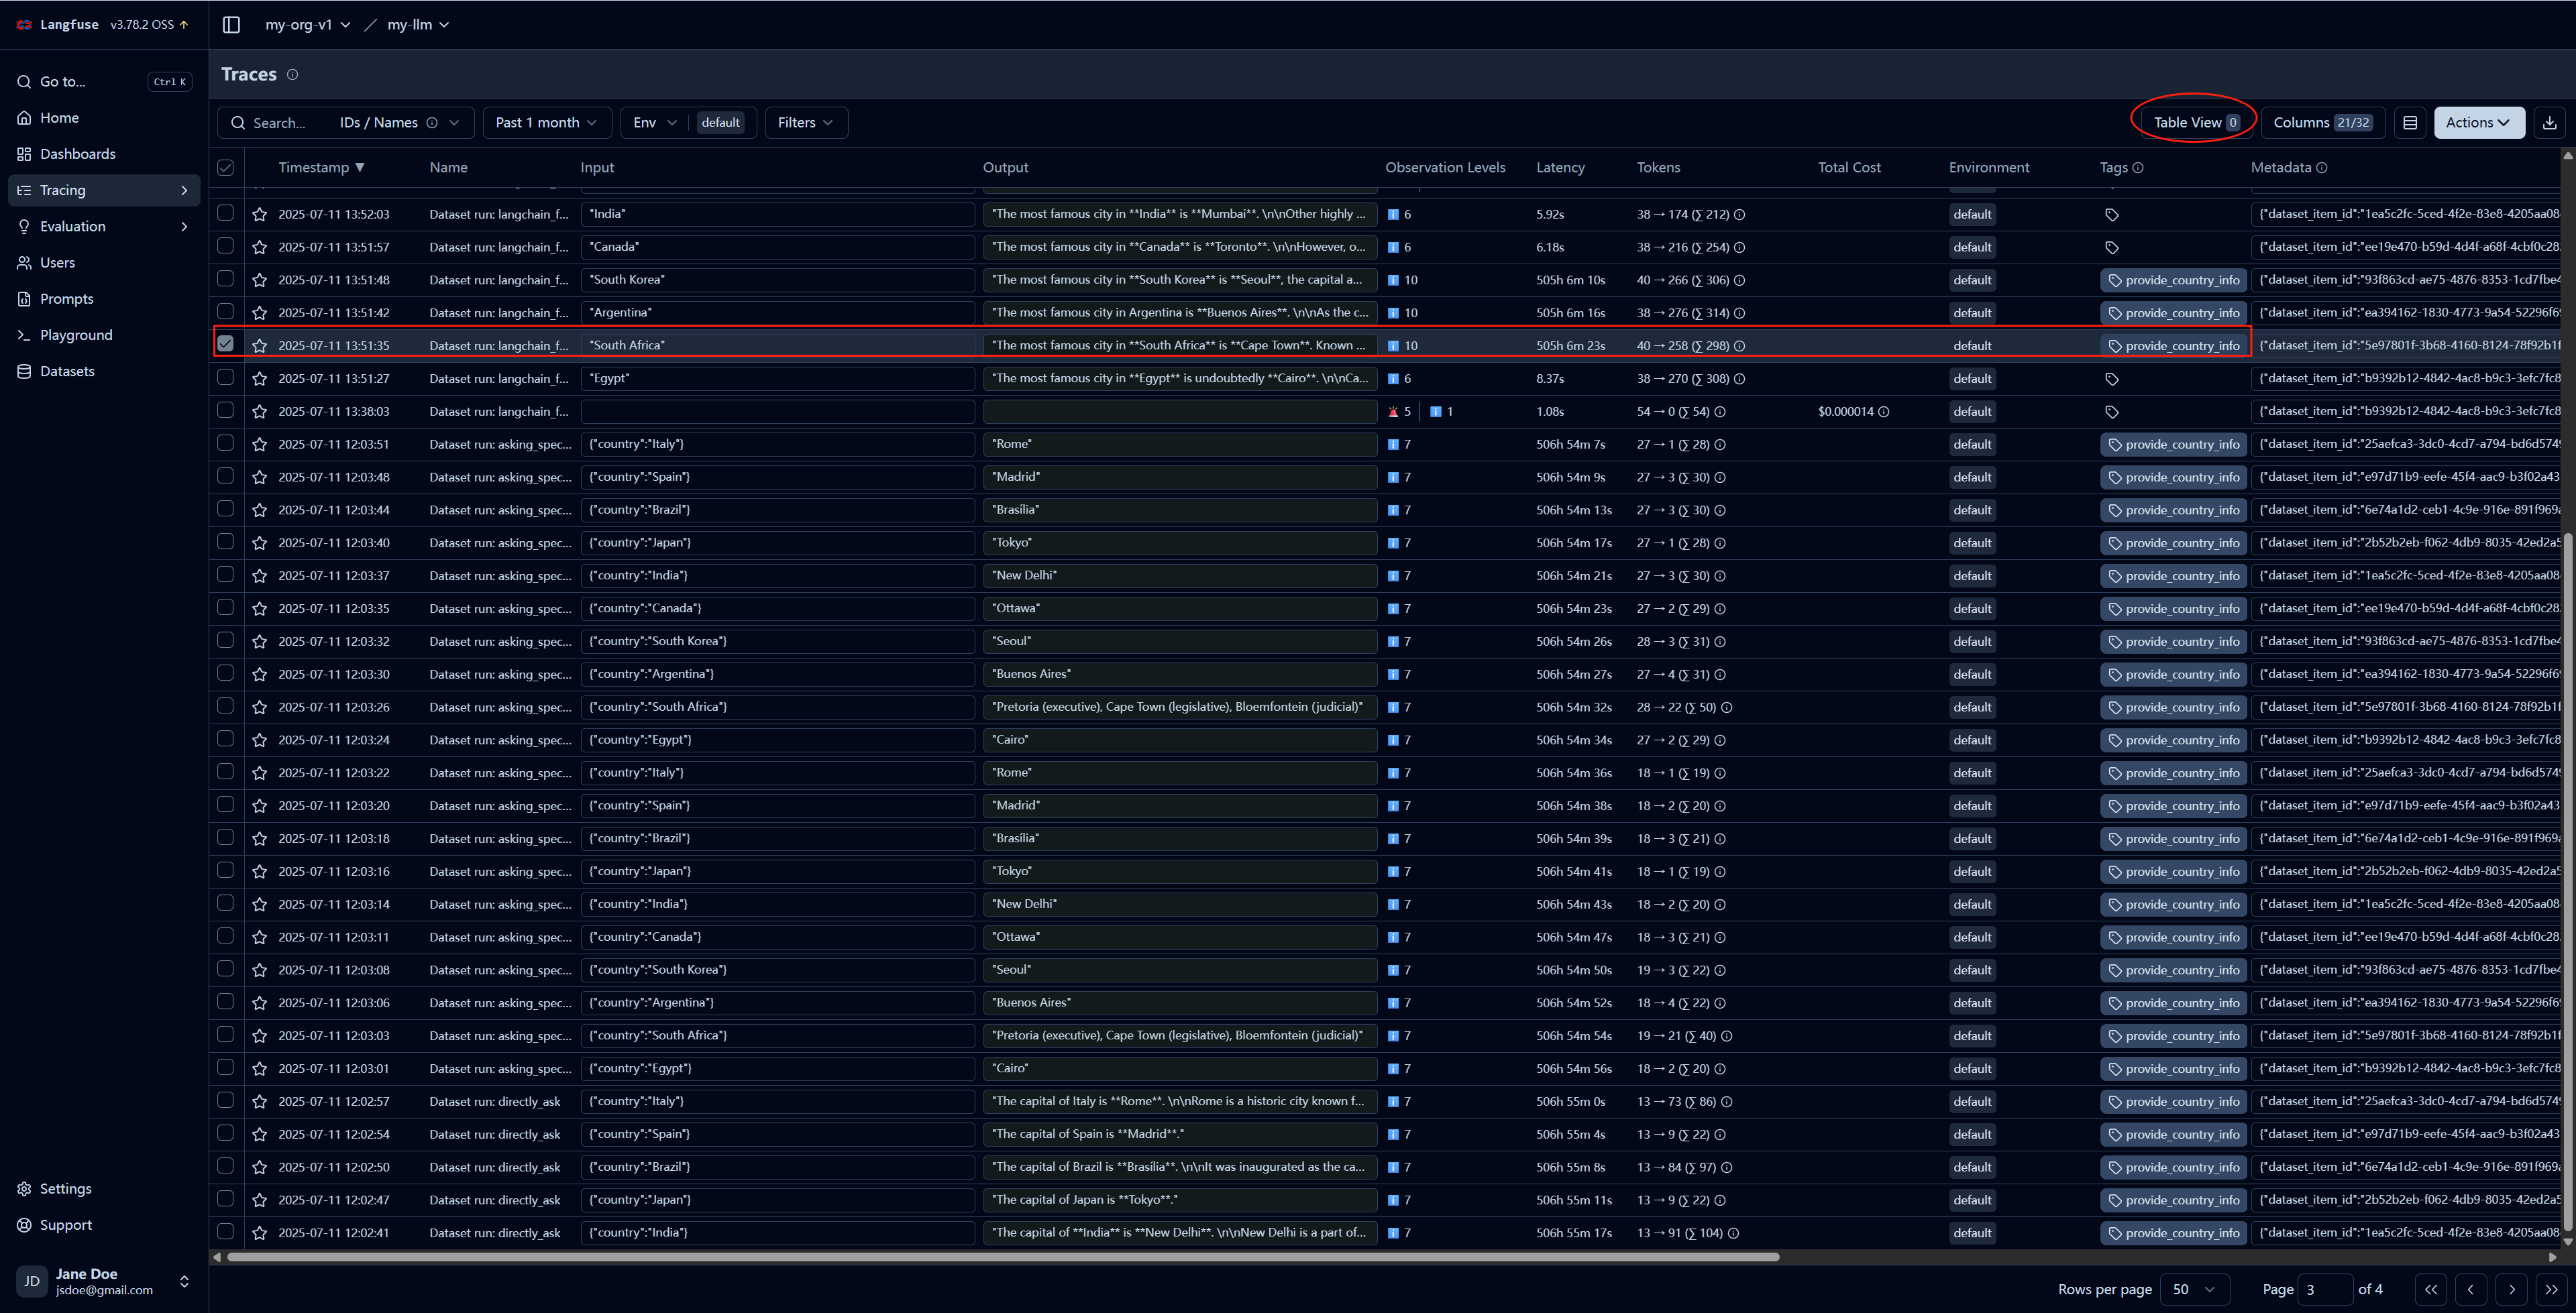



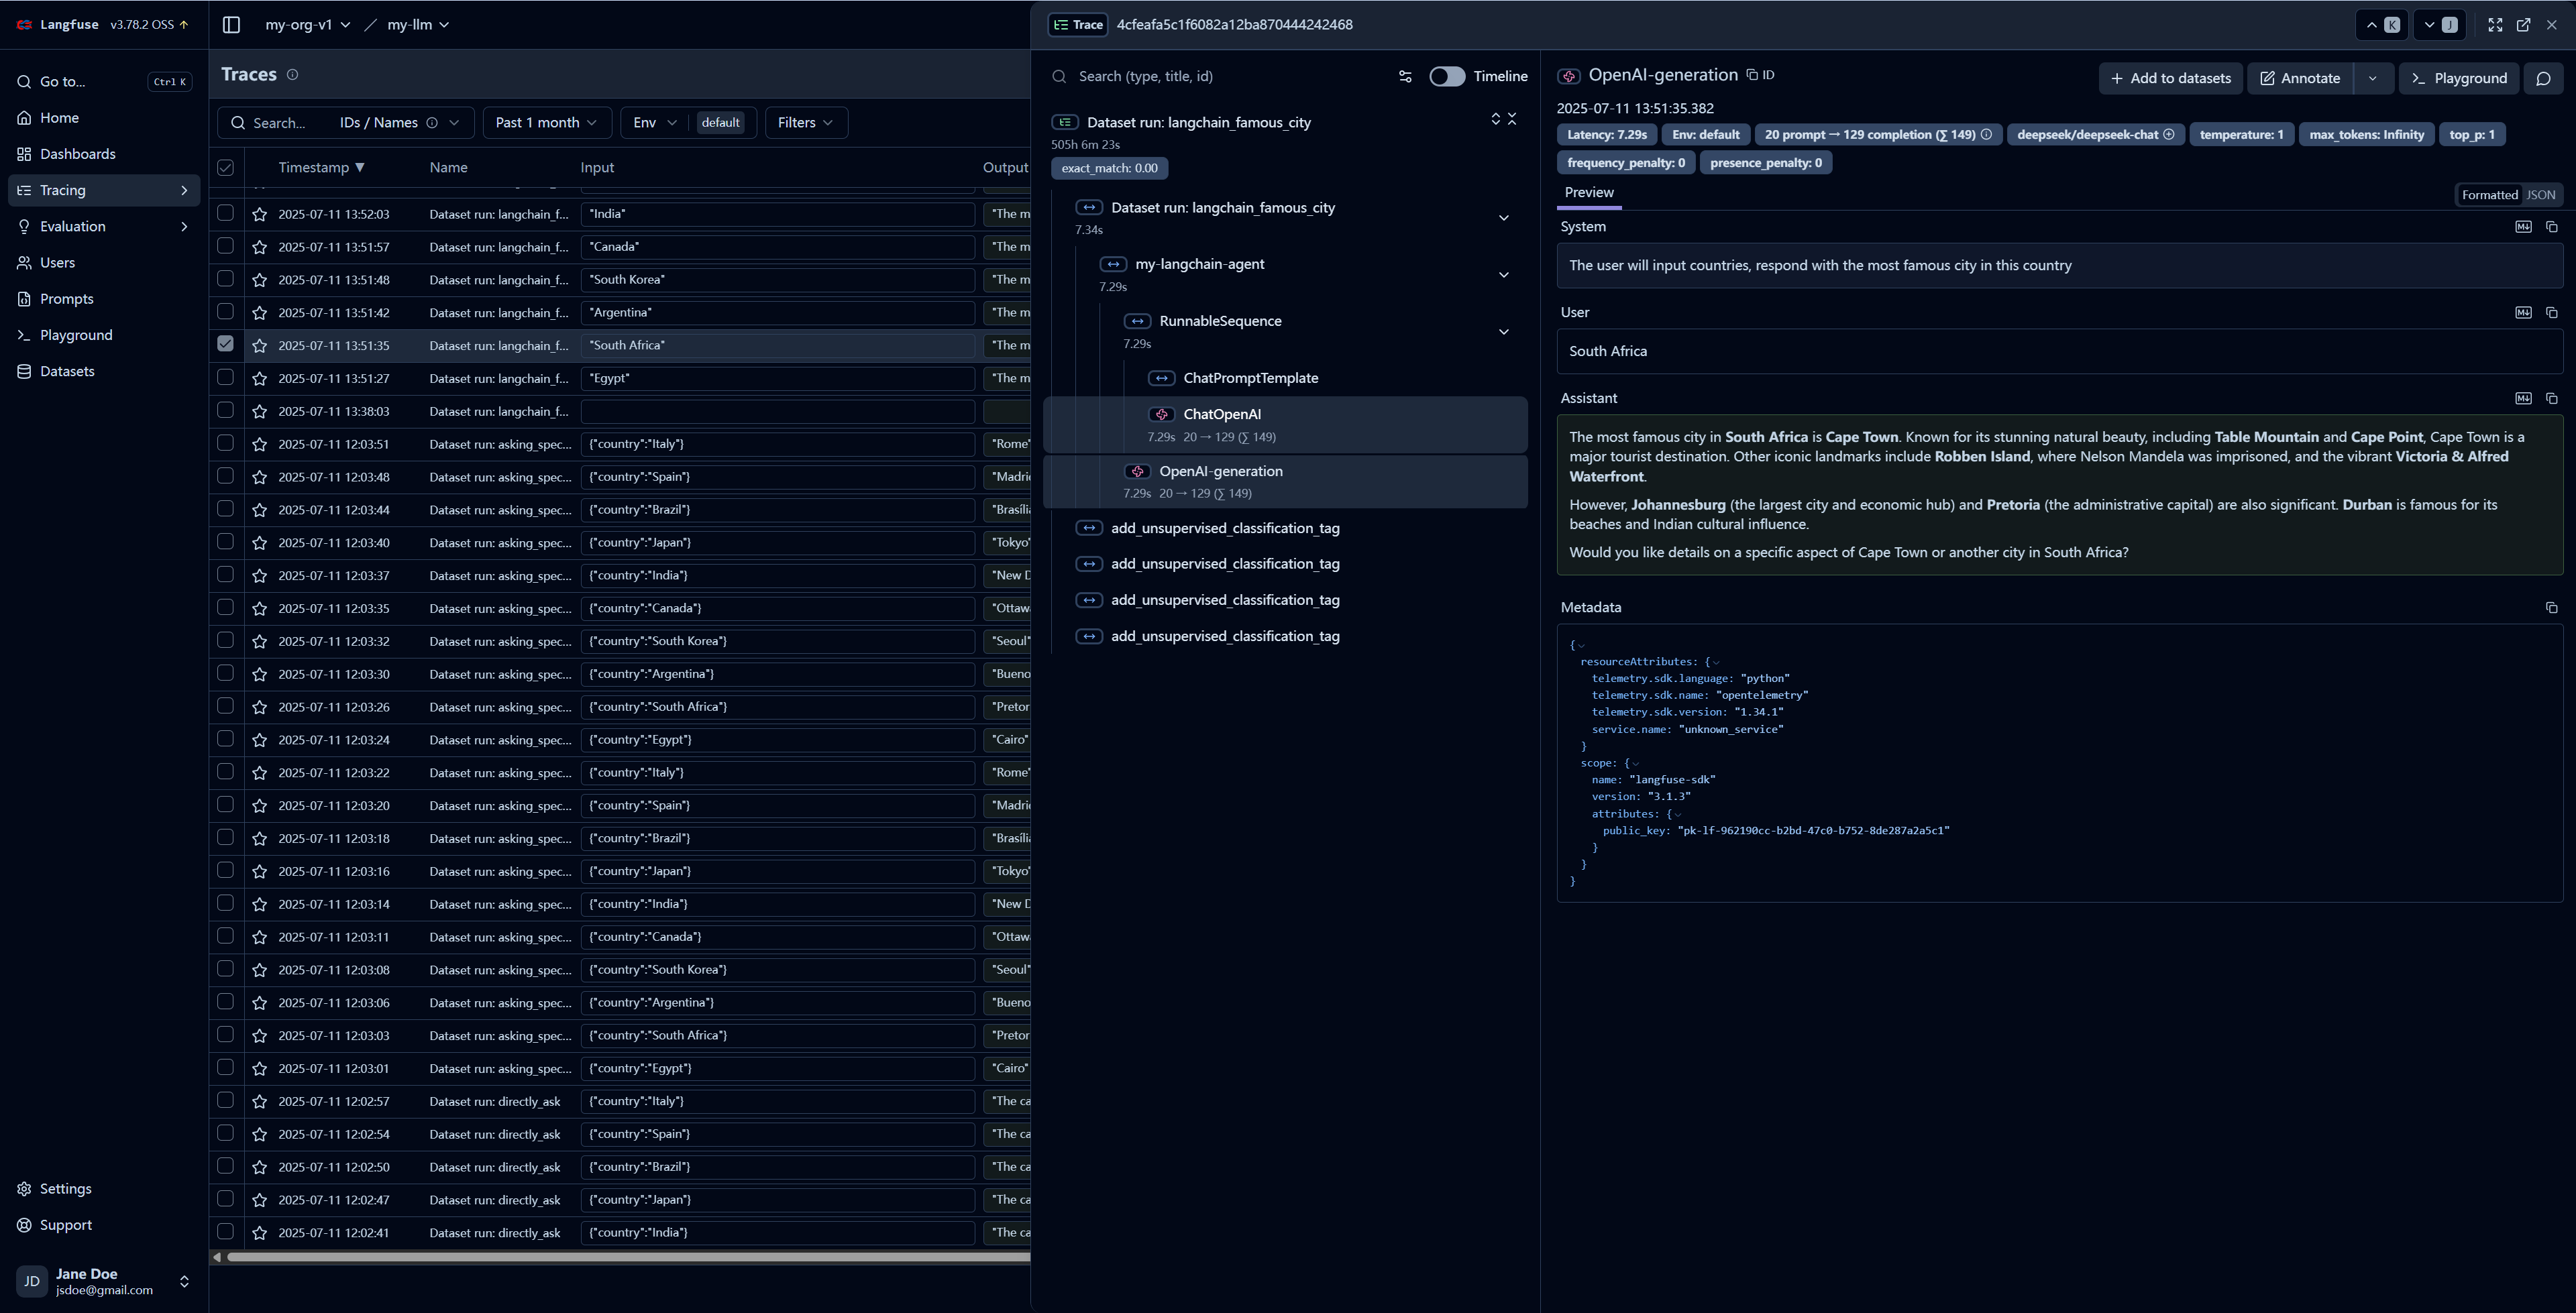